# Playing around with Brightness Temperature data

Here, we test another application of the tobac package for tracking Brightness Temperature from GOES-East Mesoscale Sector - Channel 13

In [1]:
import datetime
import shutil
from pathlib import Path
from six.moves import urllib

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import cmweather

import tobac

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
files = sorted(glob.glob("/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/*"))
files

['/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200055Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200155Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200255Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200355Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200455Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200555Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200655Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200755Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200855Z.nc',
 '/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250

In [3]:
ds = xr.open_dataset("/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/GOES19_B13_BT_20250520_200155Z.nc")
ds

<xarray.Dataset> Size: 7MB
Dimensions:                 (lat: 884, lon: 1000)
Coordinates:
  * lat                     (lat) float64 7kB 30.69 30.7 30.72 ... 43.98 44.0
  * lon                     (lon) float64 8kB -95.67 -95.66 ... -80.63 -80.62
Data variables:
    brightness_temperature  (lat, lon) float64 7MB ...
Attributes:
    description:      GOES-East Mesoscale Sector - Channel 13 Brightness Temp...
    units:            K
    source_file:      OR_ABI-L1b-RadM2-M6C13_G19_s20251402001551_e20251402002...
    processing_time:  2025-05-22T05:58:55.431466

In [4]:
import pandas as pd

In [5]:
f"20250520{ds.source_file[-10:-6]}"

'202505202002'

In [6]:
#ds.add_coords()

In [7]:
def add_time(ds):
    time_string = ds.source_file[-10:-6]

    if int(time_string) < 500:
        start_date = "20250521"
    else:
        start_date = "20250520"
        
    ds["time"] = pd.to_datetime(f"{start_date}{time_string}", format="%Y%m%d%H%M")
    ds = ds.set_coords(["time"])
    return ds

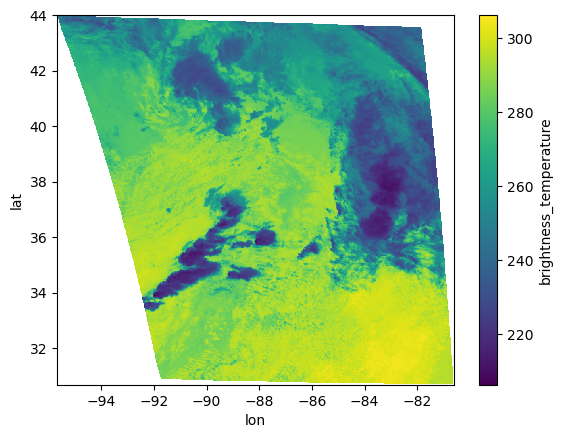

In [8]:
ds.brightness_temperature.plot()

In [9]:
files = sorted(glob.glob("/data/project/ARM_Summer_School_2025/bnf/goes_b13/output/20250520/*"))

In [10]:
ds = xr.open_mfdataset(files,
                         preprocess=add_time,
                         combine = 'nested',
                         concat_dim="time")

In [11]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:                 (time: 480, lat: 884, lon: 1000)
Coordinates:
  * lat                     (lat) float64 7kB 30.69 30.7 30.72 ... 43.98 44.0
  * lon                     (lon) float64 8kB -95.67 -95.66 ... -80.63 -80.62
  * time                    (time) datetime64[ns] 4kB 2025-05-20T20:01:00 ......
Data variables:
    brightness_temperature  (time, lat, lon) float64 3GB dask.array<chunksize=(1, 884, 1000), meta=np.ndarray>
Attributes:
    description:      GOES-East Mesoscale Sector - Channel 13 Brightness Temp...
    units:            K
    source_file:      OR_ABI-L1b-RadM2-M6C13_G19_s20251402000551_e20251402001...
    processing_time:  2025-05-22T05:58:53.401559

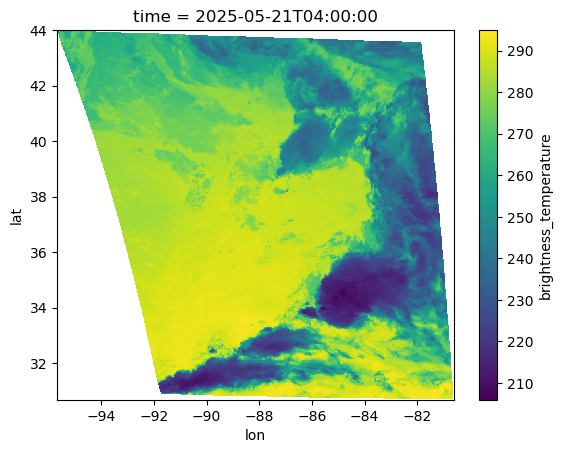

In [12]:
ds["brightness_temperature"].isel(time=-1).plot()

In [13]:
BT = ds.brightness_temperature

In [14]:
dxy = 500

In [15]:
dt = 60

In [16]:
# Keyword arguments for the feature detection step
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['n_min_threshold']=4
parameters_features['target']='minimum'
parameters_features['threshold']=[220,210,200,190]

In [17]:
# Feature detection and save results to file:
print('starting feature detection')
Features=tobac.feature_detection_multithreshold(BT,dxy,**parameters_features)
print('feature detection performed and saved')

starting feature detection
feature detection performed and saved


In [18]:
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=20
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=0
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [19]:
# Perform linking and save results to file:
Track=tobac.linking_trackpy(Features,BT,dt=dt,dxy=dxy,**parameters_linking)

Frame 479: 25 trajectories present.


In [20]:
ds.brightness_temperature.min().compute()

<xarray.DataArray 'brightness_temperature' ()> Size: 8B
array(196.04335022)

In [21]:
timeseries = ds.min(dim=["lon", "lat"]).compute()
timeseries

<xarray.Dataset> Size: 8kB
Dimensions:                 (time: 480)
Coordinates:
  * time                    (time) datetime64[ns] 4kB 2025-05-20T20:01:00 ......
Data variables:
    brightness_temperature  (time) float64 4kB 207.1 206.4 206.5 ... 205.1 206.0

In [22]:
#timeseries.brightness_temperature.plot()

Text(0.5, 1.0, 'Time series')

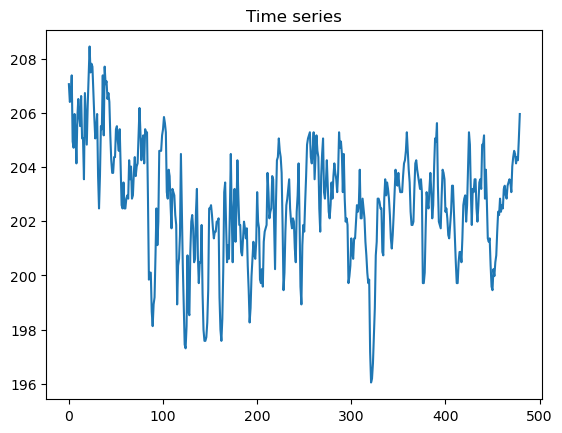

In [23]:
plt.plot(timeseries.brightness_temperature)
plt.title("Time series")

In [24]:
Features.loc[Features.threshold_value == 200]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon
1752,88,36,179.146915,263.961779,5,200,1753,2025-05-20 21:29:00,2025-05-20 21:29:00,33.387649,-91.694217
1772,89,35,180.048820,263.842493,7,200,1773,2025-05-20 21:30:00,2025-05-20 21:30:00,33.401245,-91.696014
2405,123,38,178.474576,279.872658,7,200,2406,2025-05-20 22:04:00,2025-05-20 22:04:00,33.377513,-91.454476
2428,124,36,178.510971,279.757854,6,200,2429,2025-05-20 22:05:00,2025-05-20 22:05:00,33.378062,-91.456206
2513,128,33,176.247744,281.505598,5,200,2514,2025-05-20 22:09:00,2025-05-20 22:09:00,33.343944,-91.429871
2840,143,37,276.784785,546.797957,8,200,2841,2025-05-20 22:24:00,2025-05-20 22:24:00,34.859509,-87.432514
2870,144,42,276.863862,547.554221,8,200,2871,2025-05-20 22:25:00,2025-05-20 22:25:00,34.860701,-87.421119
2899,145,46,276.646859,547.981482,8,200,2900,2025-05-20 22:26:00,2025-05-20 22:26:00,34.857430,-87.414681
2930,146,44,276.563720,548.698141,6,200,2931,2025-05-20 22:27:00,2025-05-20 22:27:00,34.856176,-87.403883
2957,147,44,276.390929,549.521808,5,200,2958,2025-05-20 22:28:00,2025-05-20 22:28:00,34.853572,-87.391472


In [25]:
Track.loc[Track.threshold_value == 200]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,cell,time_cell
1752,88,36,179.146915,263.961779,5,200,1753,2025-05-20 21:29:00,2025-05-20 21:29:00,33.387649,-91.694217,288,0 days 00:13:00
1772,89,35,180.048820,263.842493,7,200,1773,2025-05-20 21:30:00,2025-05-20 21:30:00,33.401245,-91.696014,288,0 days 00:14:00
2405,123,38,178.474576,279.872658,7,200,2406,2025-05-20 22:04:00,2025-05-20 22:04:00,33.377513,-91.454476,498,0 days 00:00:00
2428,124,36,178.510971,279.757854,6,200,2429,2025-05-20 22:05:00,2025-05-20 22:05:00,33.378062,-91.456206,498,0 days 00:01:00
2513,128,33,176.247744,281.505598,5,200,2514,2025-05-20 22:09:00,2025-05-20 22:09:00,33.343944,-91.429871,509,0 days 00:03:00
2840,143,37,276.784785,546.797957,8,200,2841,2025-05-20 22:24:00,2025-05-20 22:24:00,34.859509,-87.432514,594,0 days 00:00:00
2870,144,42,276.863862,547.554221,8,200,2871,2025-05-20 22:25:00,2025-05-20 22:25:00,34.860701,-87.421119,594,0 days 00:01:00
2899,145,46,276.646859,547.981482,8,200,2900,2025-05-20 22:26:00,2025-05-20 22:26:00,34.857430,-87.414681,594,0 days 00:02:00
2930,146,44,276.563720,548.698141,6,200,2931,2025-05-20 22:27:00,2025-05-20 22:27:00,34.856176,-87.403883,594,0 days 00:03:00
2957,147,44,276.390929,549.521808,5,200,2958,2025-05-20 22:28:00,2025-05-20 22:28:00,34.853572,-87.391472,594,0 days 00:04:00


In [26]:
single_cell_df = Track.loc[Track.cell == 594]
single_cell_df

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,cell,time_cell
2840,143,37,276.784785,546.797957,8,200,2841,2025-05-20 22:24:00,2025-05-20 22:24:00,34.859509,-87.432514,594,0 days 00:00:00
2870,144,42,276.863862,547.554221,8,200,2871,2025-05-20 22:25:00,2025-05-20 22:25:00,34.860701,-87.421119,594,0 days 00:01:00
2899,145,46,276.646859,547.981482,8,200,2900,2025-05-20 22:26:00,2025-05-20 22:26:00,34.857430,-87.414681,594,0 days 00:02:00
2930,146,44,276.563720,548.698141,6,200,2931,2025-05-20 22:27:00,2025-05-20 22:27:00,34.856176,-87.403883,594,0 days 00:03:00
2957,147,44,276.390929,549.521808,5,200,2958,2025-05-20 22:28:00,2025-05-20 22:28:00,34.853572,-87.391472,594,0 days 00:04:00
2977,148,30,276.666317,549.823337,75,210,2978,2025-05-20 22:29:00,2025-05-20 22:29:00,34.857723,-87.386929,594,0 days 00:05:00


/tmp/ipykernel_1754/147940783.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("cloud-top-temps.png", dpi=300)


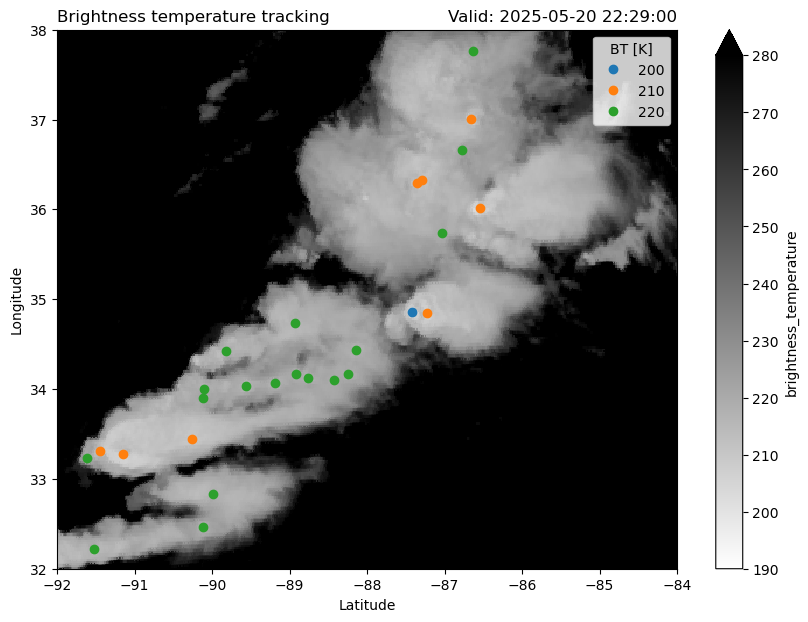

In [44]:
frame=145
plt.figure(figsize=(10, 7))
BT[frame].plot(cmap="binary", vmin=190, vmax=280)
points = {
    threshold:plt.plot(ft.lon, ft.lat, "o")[0]
    for threshold, ft in Features[Features.frame==frame].groupby("threshold_value")
}
plt.legend(list(points.values()), list(points.keys()), title="BT [K]")
plt.title("Brightness temperature tracking", loc='left')
plt.title(f'Valid: {time}', loc='right')
plt.title("", loc='center')
plt.ylim(32, 38)
plt.xlim(-92, -84)
plt.ylabel("Longitude")
plt.xlabel("Latitude")
plt.savefig("cloud-top-temps.png", dpi=300)

In [30]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:                 (time: 480, lat: 884, lon: 1000)
Coordinates:
  * lat                     (lat) float64 7kB 30.69 30.7 30.72 ... 43.98 44.0
  * lon                     (lon) float64 8kB -95.67 -95.66 ... -80.63 -80.62
  * time                    (time) datetime64[ns] 4kB 2025-05-20T20:01:00 ......
Data variables:
    brightness_temperature  (time, lat, lon) float64 3GB dask.array<chunksize=(1, 884, 1000), meta=np.ndarray>
Attributes:
    description:      GOES-East Mesoscale Sector - Channel 13 Brightness Temp...
    units:            K
    source_file:      OR_ABI-L1b-RadM2-M6C13_G19_s20251402000551_e20251402001...
    processing_time:  2025-05-22T05:58:53.401559

In [31]:
timeseries_ds_list = []
for time in single_cell_df.time:
    subset = single_cell_df.loc[single_cell_df.time == time]
    timeseries_ds_list.append(ds.sel(time=subset.time.values,
                                     lat=subset.lat.values,
                                     lon=subset.lon.values,
                                     method='nearest').squeeze())
single_cell_ds = xr.concat(timeseries_ds_list, dim="time")
single_cell_ds

<xarray.Dataset> Size: 192B
Dimensions:                 (time: 6)
Coordinates:
    lat                     (time) float64 48B 34.86 34.86 34.86 ... 34.85 34.86
    lon                     (time) float64 48B -87.43 -87.41 ... -87.38 -87.38
  * time                    (time) datetime64[ns] 48B 2025-05-20T22:24:00 ......
Data variables:
    brightness_temperature  (time) float64 48B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    description:      GOES-East Mesoscale Sector - Channel 13 Brightness Temp...
    units:            K
    source_file:      OR_ABI-L1b-RadM2-M6C13_G19_s20251402000551_e20251402001...
    processing_time:  2025-05-22T05:58:53.401559

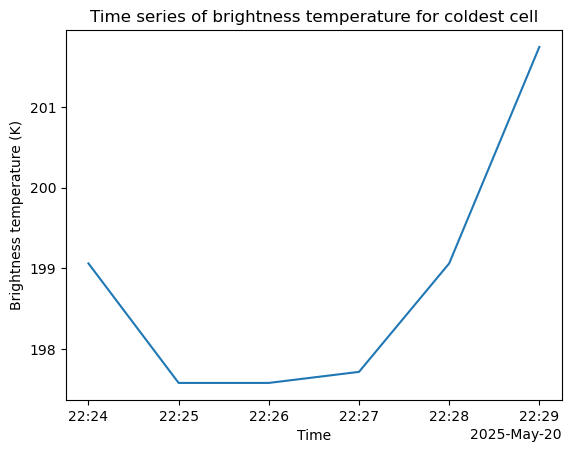

In [45]:
single_cell_ds.brightness_temperature.plot()
plt.title("Time series of brightness temperature for coldest cell")
plt.ylabel("Brightness temperature (K)")
plt.xlabel("Time")
plt.savefig("cloud-top-temps-timeseries.png", dpi=300)

In [ ]:
# Keyword arguments for the feature detection step
#parameters_features={}
#parameters_features['position_threshold']='weighted_diff'
#parameters_features['sigma_threshold']=0.5
#parameters_features['n_min_threshold']=10
#parameters_features['target']='minimum'
#parameters_features['threshold']=[220,210,200,190]

# Feature detection and save results to file:
#print('starting feature detection')
#Features=tobac.feature_detection_multithreshold(BT,dxy,**parameters_features)
#print('feature detection performed and saved')

# keyword arguments for linking step
#parameters_linking={}
#parameters_linking['v_max']=20
#parameters_linking['stubs']=2
#parameters_linking['order']=1
#parameters_linking['extrapolate']=0
#parameters_linking['memory']=0
#parameters_linking['adaptive_stop']=0.2
#parameters_linking['adaptive_step']=0.95
#parameters_linking['subnetwork_size']=100
#parameters_linking['method_linking']= 'predict'

# Perform linking and save results to file:
#Track=tobac.linking_trackpy(Features,BT,dt=dt,dxy=dxy,**parameters_linking)

In [ ]:
#frame=145
#BT[frame].plot(cmap="binary")
#points = {
#    threshold:plt.plot(ft.lon, ft.lat, "o")[0]
#    for threshold, ft in Features[Features.frame==frame].groupby("threshold_value")
#}
#plt.legend(list(points.values()), list(points.keys()), title="BT [K]")